# Import de fonctions

In [ ]:
from numpy.random import seed
seed(3)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import v_measure_score
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import numpy as np
import datetime
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Dataset des chiffres du MNIST
from keras.datasets import mnist

In [ ]:
# Fonction pour afficher les données matricielles sous forme d'images
def display_image(X, y, n, label=False):
    dim = 32
    fig, axs = plt.subplots(n, n, figsize=(5,5))

    for i in range(n):
      for j in range(n):
        axs[i,j].imshow(X[j*n+i].reshape((dim,dim)), cmap='gray')
        axs[i,j].axis('off')
    plt.show()

In [ ]:
colors_per_cluster = {
                      -1:np.array([0.4,0.4,0.4]),
                      0:np.array([0.9,0.05,0.05]),
                      1:np.array([0.15,0.15,0.85])
                      }

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# Compute the coordinates of the image on the plot
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset=16):
    image_height, image_width, _ = image.shape
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height
    return tl_x, tl_y, br_x, br_y

def draw_rectangle_by_conditional_pred(image, label_pred_conditionnaly_to_cluster, plot_neg=True, false_pred=False) :
  image = np.stack((image,)*3, axis=-1)

  if false_pred :
    color = np.array([0.05,1,0.05])
  elif plot_neg :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[0])
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[1])
    color = color / 2
  else :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0]
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1]
  image[1,:,:] = color
  image[:,-2,:] = color
  image[-2,:,:] = color
  image[:,1,:] = color
  return image

def create_visualization(two_dim_latent_space, X_test, y_test, y_ground_truth, y_pred) :
  img_dim = 32
  offset = img_dim // 2 + 1
  huge_image_size = 2*275

  # extract x and y coordinates representing the positions of the images on T-SNE plot
  two_dim_latent_space = StandardScaler().fit_transform(two_dim_latent_space)
  tx = two_dim_latent_space[:, 0]
  ty = two_dim_latent_space[:, 1]
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # init the plot as white canvas
  tsne_plot = np.ones((huge_image_size+2*offset+1, huge_image_size+2*offset+1, 3))

  c=0
  t=0
  # now we'll put a small copy of every image to its corresponding latent space coordinate
  for image, label, pred, x, y in zip(X_test, y_test, y_pred, tx, ty) :
      if label != 7 :
        if np.random.uniform(0,1) > 0.99 :
          continue
      elif c >= len(y_ground_truth) :
        continue
      else :
        cluster=y_ground_truth[c]
        c+=1
      image = np.reshape(image, (img_dim,img_dim))
      if label==7 and pred==cluster :
        image = draw_rectangle_by_conditional_pred(image, {0:(1-cluster), 1:cluster}, plot_neg=False)
      if label==7 and pred!=cluster :
        image = draw_rectangle_by_conditional_pred(image, {0:0.5, 1:0.5}, false_pred=True)
      if label!=7 :
        image = draw_rectangle_by_conditional_pred(image, {0:0, 1:0})
      # compute the coordinates of the image on the scaled plot visualization
      tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, huge_image_size)
      # put the image to its t-SNE coordinates using numpy sub-array indices
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/2 > (img_dim**2-(offset-2)**2) :
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
        t=t+1


  fig = plt.figure(figsize=(10, 10))

  legend_elements = [Patch(label='Rest (Label -1)', fill=False, edgecolor='#999999', linewidth=3),
                    Patch(label='True Cluster A Prediction', fill=False, edgecolor='b', linewidth=3),
                    Patch(label='True Cluster B Prediction', fill=False, edgecolor='r', linewidth=3),
                    Patch(label='False Prediction', fill=False, edgecolor=[0.15,0.85,0.15], linewidth=3),]

  plt.axis('off')
  plt.legend(handles=legend_elements, loc='lower right', prop={'size': 10})
  plt.imshow(tsne_plot)
  plt.show()


In [ ]:
# load ground truth label
import json

label_mapping_seven = {'No bar':0, 'With bar':1}
with open("/content/drive/MyDrive/Neurospin/Thèse Robin/UCSL/mnist_labels.json") as json_file:
    ground_truth_dict = json.load(json_file)
    y_ground_truth = np.array([label_mapping_seven[ground_truth_dict[key]] for key in ground_truth_dict.keys()])

# Define models and datasets

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

pos_label = 7

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array([np.pad(img, 2) for img in X_train])
X_test = np.array([np.pad(img, 2) for img in X_test])

train_indices = []
test_indices = []

c=0
for (i, y_i) in enumerate(y_train) :
  if y_i in [pos_label] :
    train_indices.append(i)
    c+=1
  else :
    if len(train_indices) < 2*c :
      train_indices.append(i)

c=0
for (i, y_i) in enumerate(y_test) :
  if y_i in [pos_label] :
    test_indices.append(i)
    c+=1
  else :
    if len(test_indices) < 2*c :
      test_indices.append(i)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

X_train = X_train[train_indices]
X_test = X_test[test_indices]
y_train = y_train[train_indices]
y_test = y_test[test_indices]

# flatten the images
n_samples_train = len(X_train)
X_train = X_train.reshape((n_samples_train, -1))
X_train = X_train - np.min(X_train, 1)[:, None]
X_train = X_train / np.max(X_train, 1)[:, None]

n_samples_test = len(X_test)
X_test = X_test.reshape((n_samples_test, -1))
X_test = X_test - np.min(X_test, 1)[:, None]
X_test = X_test / np.max(X_test, 1)[:, None]

X_train = np.array(X_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
y_train = np.array(y_train).astype(np.float)
y_test = np.array(y_test).astype(np.float)

X_train = np.reshape(X_train, (-1, 32, 32))
X_test = np.reshape(X_test, (-1, 32, 32))

train_positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_train) if y_i in [pos_label]]).astype(np.int)
train_negative_labels_indices = np.array([i for (i, y_i) in enumerate(y_train) if y_i not in [pos_label]]).astype(np.int)
test_positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_test) if y_i in [pos_label]]).astype(np.int)


<ipython-input-6-c0cb804888fa>:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = np.array(X_train).astype(np.float)
<ipython-input-6-c0cb804888fa>:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = np.array(X_test).astype(np.float)
<ipython-input-6-c0cb804888fa>:60: DeprecationWarning: `np.float` is a deprecated alias fo

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, target, test=False):
        self.data = data
        self.target = torch.from_numpy(target).float()
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomRotation(25),
                            transforms.RandomAffine(15, translate=(0.1, 0.1), shear=0.1),
                        ])
        self.test = test

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        x = self.data[index]
        y = torch.tensor(self.target[index])
        if self.test :
          x_1 = torch.tensor(x)[None,:,:].float()
        else :
          x_1 = self.transform(x).float()
        return x_1.cuda(), y.cuda()


# load the training and test datasets
y_train_binary = np.array([1 if y_i in [pos_label] else 0 for (i, y_i) in enumerate(y_train)])
y_test_binary = np.array([1 if y_i in [pos_label] else 0 for (i, y_i) in enumerate(y_test)])

# training and testing dataset
train_data = MyDataset(X_train, y_train_binary)
test_data = MyDataset(X_test, y_test_binary, test=True)


In [ ]:
# Encoder model
class SimpleConvNet(nn.Module):
    def __init__(self, nc, nz, kernel_size=7):
        super(SimpleConvNet, self).__init__()
        padding = kernel_size // 2
        layers = [
            nn.Conv2d(nc, 16, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        ]
        self.extracter = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, nz)
        self.fc2 = nn.Linear(nz, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded_features = self.extracter(x)
        encoded_features = self.avgpool(encoded_features)
        encoded_features = torch.flatten(encoded_features, 1)
        latent_features = self.fc1(encoded_features)
        probabilities = self.sigmoid(self.fc2(nn.ReLU()(latent_features)))
        return probabilities, encoded_features

# model parameters
nz = 128
nc = 1


# Deep Classification + Clustering

<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 1 	Training Loss: 83.847212
         	Testing Loss: 71.256150
         	Testing Acc: 0.840533
         	Training Acc: 0.657987
Epoch: 2 	Training Loss: 69.461819
         	Testing Loss: 52.871083
         	Testing Acc: 0.921875
         	Training Acc: 0.859546
Epoch: 3 	Training Loss: 56.319329
         	Testing Loss: 42.493392
         	Testing Acc: 0.962316
         	Training Acc: 0.919534
Epoch: 4 	Training Loss: 47.826453
         	Testing Loss: 35.118208
         	Testing Acc: 0.980239
         	Training Acc: 0.938717
Epoch: 5 	Training Loss: 42.505619
         	Testing Loss: 30.559829
         	Testing Acc: 0.981158
         	Training Acc: 0.942901
Epoch: 6 	Training Loss: 37.759458
         	Testing Loss: 26.961198
         	Testing Acc: 0.982537
         	Training Acc: 0.950415
Epoch: 7 	Training Loss: 34.303982
         	Testing Loss: 23.794664
         	Testing Acc: 0.984375
         	Training Acc: 0.954142
Epoch: 8 	Training Loss: 31.125442
         	Testing Loss: 21.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.7604719662979074


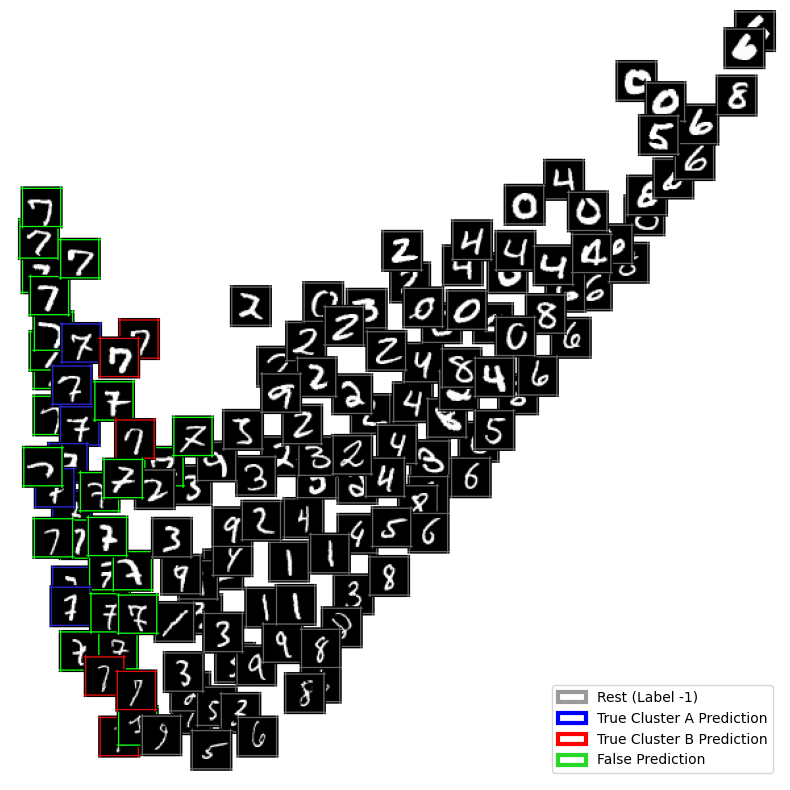

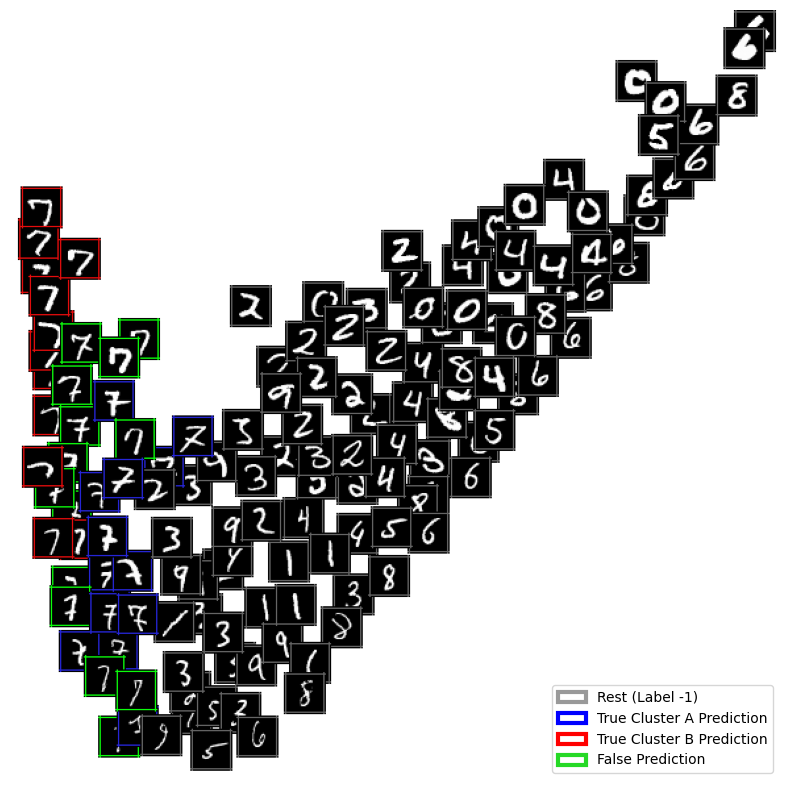

------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 11 	Training Loss: 23.962638
         	Testing Loss: 15.843552
         	Testing Acc: 0.989430
         	Training Acc: 0.966479
Epoch: 12 	Training Loss: 21.873612
         	Testing Loss: 14.457500
         	Testing Acc: 0.988971
         	Training Acc: 0.969528
Epoch: 13 	Training Loss: 20.472872
         	Testing Loss: 13.458454
         	Testing Acc: 0.988511
         	Training Acc: 0.969368
Epoch: 14 	Training Loss: 18.945799
         	Testing Loss: 12.148512
         	Testing Acc: 0.990809
         	Training Acc: 0.970395
Epoch: 15 	Training Loss: 17.795178
         	Testing Loss: 13.308510
         	Testing Acc: 0.983915
         	Training Acc: 0.971351
Epoch: 16 	Training Loss: 16.148934
         	Testing Loss: 10.552910
         	Testing Acc: 0.990809
         	Training Acc: 0.976234
Epoch: 17 	Training Loss: 15.580936
         	Testing Loss: 10.636059
         	Testing Acc: 0.988511
         	Training Acc: 0.974729
Epoch: 18 	Training Loss: 14.434243
         	Testing L

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6854985101209028


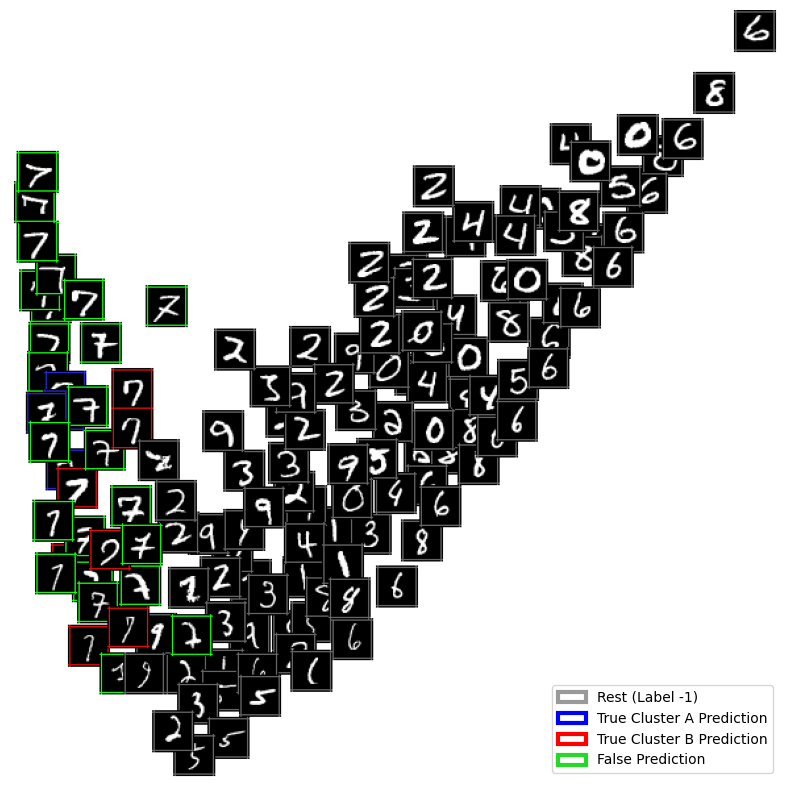

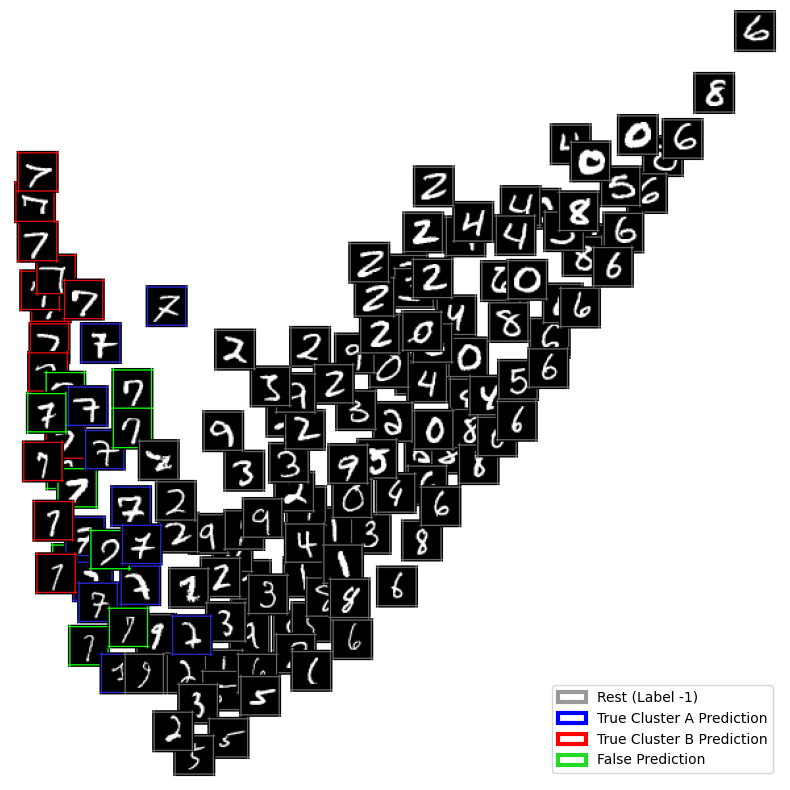

------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 21 	Training Loss: 12.265137
         	Testing Loss: 7.559150
         	Testing Acc: 0.991728
         	Training Acc: 0.977260
Epoch: 22 	Training Loss: 11.924121
         	Testing Loss: 6.720855
         	Testing Acc: 0.993107
         	Training Acc: 0.979014
Epoch: 23 	Training Loss: 10.801745
         	Testing Loss: 7.629675
         	Testing Acc: 0.989430
         	Training Acc: 0.981804
Epoch: 24 	Training Loss: 10.530339
         	Testing Loss: 6.180997
         	Testing Acc: 0.991728
         	Training Acc: 0.980449
Epoch: 25 	Training Loss: 9.949964
         	Testing Loss: 5.212096
         	Testing Acc: 0.994026
         	Training Acc: 0.980529
Epoch: 26 	Training Loss: 9.831437
         	Testing Loss: 5.094061
         	Testing Acc: 0.994485
         	Training Acc: 0.981106
Epoch: 27 	Training Loss: 9.193685
         	Testing Loss: 5.681592
         	Testing Acc: 0.992188
         	Training Acc: 0.980360
Epoch: 28 	Training Loss: 9.094109
         	Testing Loss: 4.7560

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6314861115868069


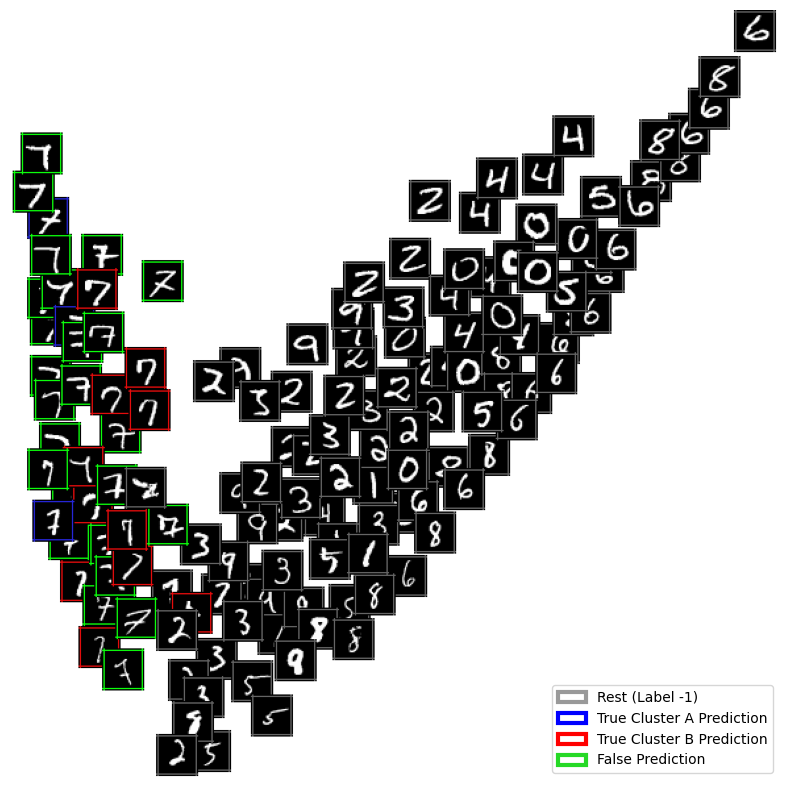

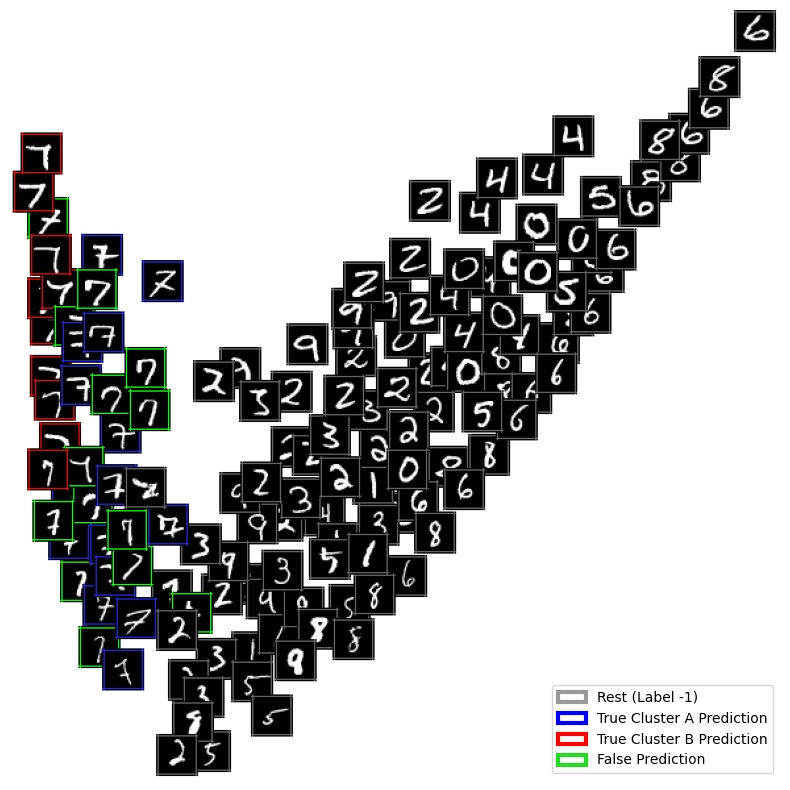

------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 31 	Training Loss: 8.412078
         	Testing Loss: 3.895439
         	Testing Acc: 0.994485
         	Training Acc: 0.980947
Epoch: 32 	Training Loss: 7.902727
         	Testing Loss: 4.596062
         	Testing Acc: 0.992647
         	Training Acc: 0.983418
Epoch: 33 	Training Loss: 7.362406
         	Testing Loss: 4.451452
         	Testing Acc: 0.993107
         	Training Acc: 0.984754
Epoch: 34 	Training Loss: 7.340504
         	Testing Loss: 3.544719
         	Testing Acc: 0.994026
         	Training Acc: 0.983020
Epoch: 35 	Training Loss: 7.453903
         	Testing Loss: 3.497189
         	Testing Acc: 0.994026
         	Training Acc: 0.982761
Epoch: 36 	Training Loss: 6.549058
         	Testing Loss: 3.287569
         	Testing Acc: 0.994485
         	Training Acc: 0.985720
Epoch: 37 	Training Loss: 6.419304
         	Testing Loss: 3.614566
         	Testing Acc: 0.994026
         	Training Acc: 0.984614
Epoch: 38 	Training Loss: 6.728840
         	Testing Loss: 5.482830
 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.626211597081892


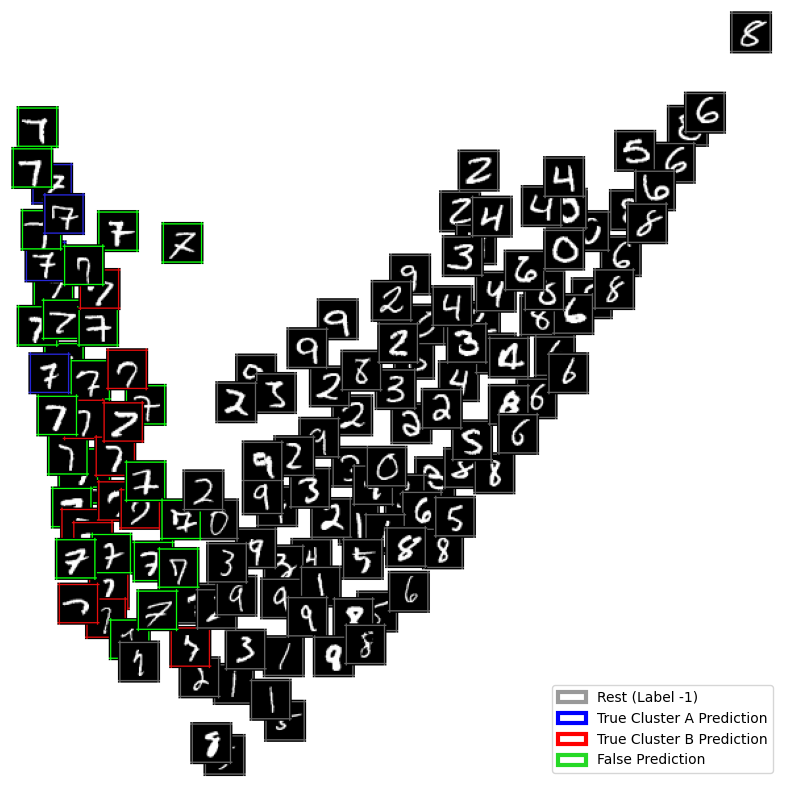

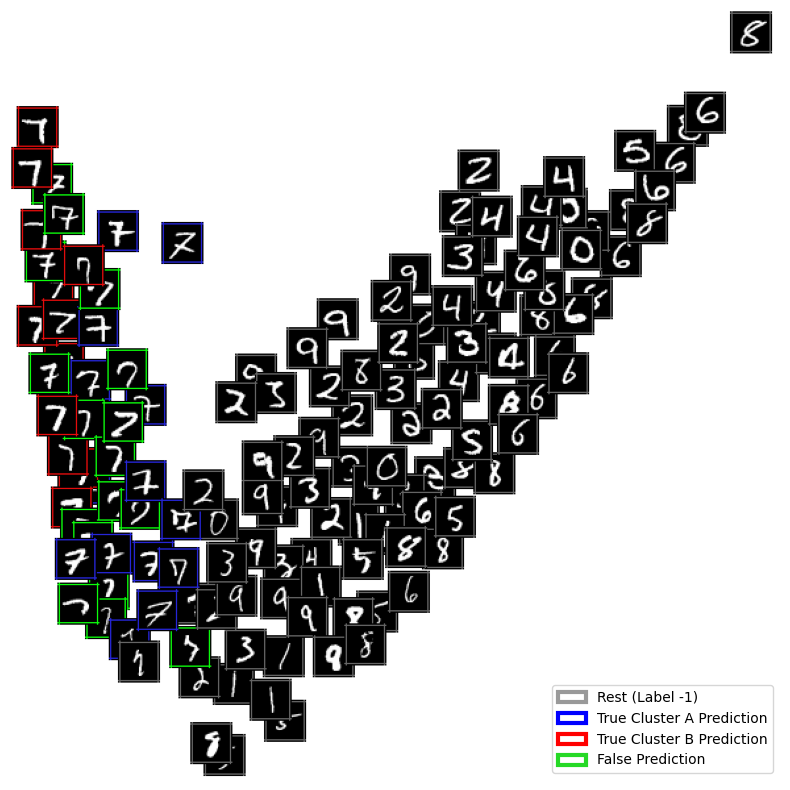

------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 41 	Training Loss: 6.193509
         	Testing Loss: 3.178512
         	Testing Acc: 0.994485
         	Training Acc: 0.984744
Epoch: 42 	Training Loss: 5.788964
         	Testing Loss: 2.556357
         	Testing Acc: 0.994485
         	Training Acc: 0.985650
Epoch: 43 	Training Loss: 5.892725
         	Testing Loss: 2.682283
         	Testing Acc: 0.993566
         	Training Acc: 0.985711
Epoch: 44 	Training Loss: 5.938161
         	Testing Loss: 2.587031
         	Testing Acc: 0.994026
         	Training Acc: 0.985650
Epoch: 45 	Training Loss: 5.795892
         	Testing Loss: 3.320937
         	Testing Acc: 0.994485
         	Training Acc: 0.986288
Epoch: 46 	Training Loss: 5.472168
         	Testing Loss: 2.705836
         	Testing Acc: 0.995404
         	Training Acc: 0.986527
Epoch: 47 	Training Loss: 5.257732
         	Testing Loss: 2.928411
         	Testing Acc: 0.995404
         	Training Acc: 0.987085
Epoch: 48 	Training Loss: 5.248691
         	Testing Loss: 2.158339
 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6286776038634105


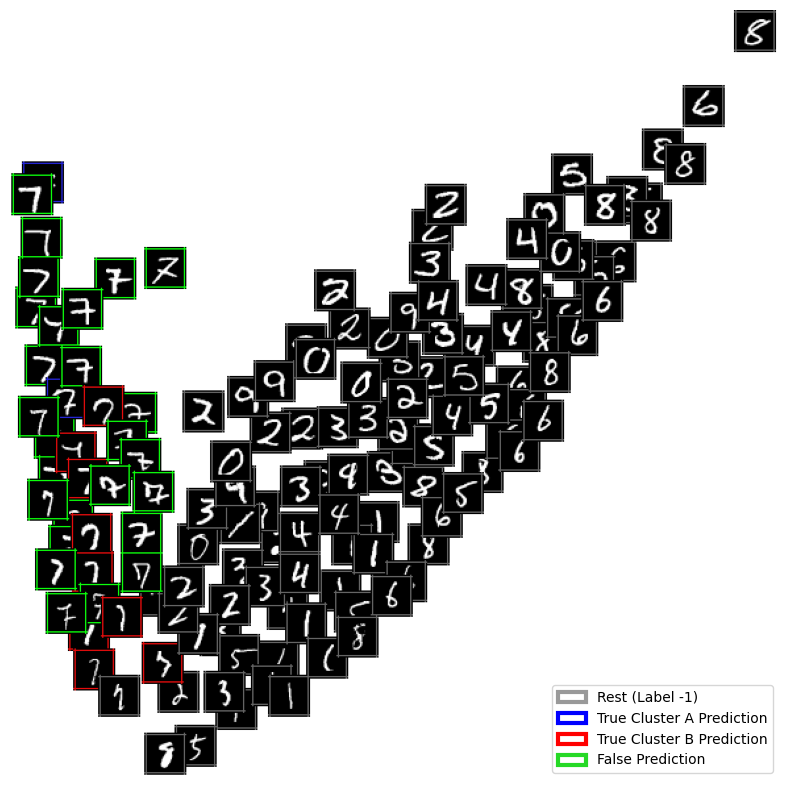

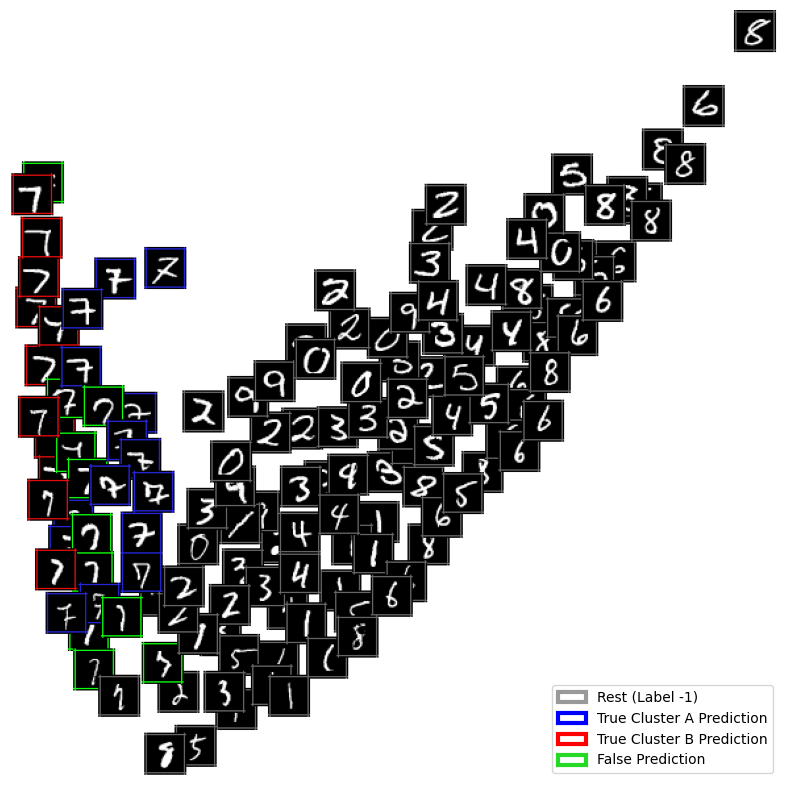

------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 1 	Training Loss: 84.812042
         	Testing Loss: 74.539993
         	Testing Acc: 0.738051
         	Training Acc: 0.699261
Epoch: 2 	Training Loss: 73.262867
         	Testing Loss: 57.186532
         	Testing Acc: 0.902114
         	Training Acc: 0.860562
Epoch: 3 	Training Loss: 62.186319
         	Testing Loss: 48.849300
         	Testing Acc: 0.935202
         	Training Acc: 0.898299
Epoch: 4 	Training Loss: 54.963554
         	Testing Loss: 42.615386
         	Testing Acc: 0.957721
         	Training Acc: 0.929230
Epoch: 5 	Training Loss: 48.960226
         	Testing Loss: 37.643938
         	Testing Acc: 0.975184
         	Training Acc: 0.941058
Epoch: 6 	Training Loss: 44.120055
         	Testing Loss: 32.882700
         	Testing Acc: 0.978860
         	Training Acc: 0.947994
Epoch: 7 	Training Loss: 39.487387
         	Testing Loss: 29.355004
         	Testing Acc: 0.982996
         	Training Acc: 0.954202
Epoch: 8 	Training Loss: 35.668992
         	Testing Loss: 25.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.721015857793609
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 11 	Training Loss: 27.184784
         	Testing Loss: 18.291401
         	Testing Acc: 0.987592
         	Training Acc: 0.965223
Epoch: 12 	Training Loss: 24.773298
         	Testing Loss: 16.418946
         	Testing Acc: 0.988971
         	Training Acc: 0.968970
Epoch: 13 	Training Loss: 22.955995
         	Testing Loss: 15.064521
         	Testing Acc: 0.989430
         	Training Acc: 0.969856
Epoch: 14 	Training Loss: 21.338063
         	Testing Loss: 13.759962
         	Testing Acc: 0.988511
         	Training Acc: 0.971371
Epoch: 15 	Training Loss: 19.580658
         	Testing Loss: 12.429150
         	Testing Acc: 0.990349
         	Training Acc: 0.974231
Epoch: 16 	Training Loss: 18.072418
         	Testing Loss: 11.365571
         	Testing Acc: 0.991268
         	Training Acc: 0.976055
Epoch: 17 	Training Loss: 17.237233
         	Testing Loss: 10.864643
         	Testing Acc: 0.989430
         	Training Acc: 0.973842
Epoch: 18 	Training Loss: 16.173532
         	Testing L

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.7022810562729047
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 21 	Training Loss: 13.288491
         	Testing Loss: 7.803741
         	Testing Acc: 0.991268
         	Training Acc: 0.978635
Epoch: 22 	Training Loss: 12.817770
         	Testing Loss: 7.000806
         	Testing Acc: 0.993107
         	Training Acc: 0.977828
Epoch: 23 	Training Loss: 12.281591
         	Testing Loss: 6.922625
         	Testing Acc: 0.993107
         	Training Acc: 0.978944
Epoch: 24 	Training Loss: 11.334816
         	Testing Loss: 6.125108
         	Testing Acc: 0.993566
         	Training Acc: 0.981425
Epoch: 25 	Training Loss: 10.784001
         	Testing Loss: 6.096081
         	Testing Acc: 0.993566
         	Training Acc: 0.981346
Epoch: 26 	Training Loss: 10.076470
         	Testing Loss: 5.833497
         	Testing Acc: 0.993107
         	Training Acc: 0.983389
Epoch: 27 	Training Loss: 9.719402
         	Testing Loss: 5.482053
         	Testing Acc: 0.994026
         	Training Acc: 0.982930
Epoch: 28 	Training Loss: 9.418444
         	Testing Loss: 5.11

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.674384354556975
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 31 	Training Loss: 8.398997
         	Testing Loss: 4.552593
         	Testing Acc: 0.994945
         	Training Acc: 0.983578
Epoch: 32 	Training Loss: 7.592707
         	Testing Loss: 4.068410
         	Testing Acc: 0.994026
         	Training Acc: 0.985561
Epoch: 33 	Training Loss: 7.722561
         	Testing Loss: 3.847957
         	Testing Acc: 0.993107
         	Training Acc: 0.986527
Epoch: 34 	Training Loss: 7.143799
         	Testing Loss: 3.663751
         	Testing Acc: 0.993107
         	Training Acc: 0.986129
Epoch: 35 	Training Loss: 7.148352
         	Testing Loss: 4.779109
         	Testing Acc: 0.990349
         	Training Acc: 0.985242
Epoch: 36 	Training Loss: 6.701276
         	Testing Loss: 3.433560
         	Testing Acc: 0.993107
         	Training Acc: 0.987155
Epoch: 37 	Training Loss: 6.725894
         	Testing Loss: 3.552783
         	Testing Acc: 0.994945
         	Training Acc: 0.986767
Epoch: 38 	Training Loss: 6.773990
         	Testing Loss: 3.279534
 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6416241394663835
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 41 	Training Loss: 6.141846
         	Testing Loss: 2.777359
         	Testing Acc: 0.995404
         	Training Acc: 0.987404
Epoch: 42 	Training Loss: 5.993774
         	Testing Loss: 2.812682
         	Testing Acc: 0.994945
         	Training Acc: 0.986757
Epoch: 43 	Training Loss: 5.913018
         	Testing Loss: 2.826651
         	Testing Acc: 0.995404
         	Training Acc: 0.986926
Epoch: 44 	Training Loss: 5.705950
         	Testing Loss: 2.632626
         	Testing Acc: 0.994026
         	Training Acc: 0.986916
Epoch: 45 	Training Loss: 5.889261
         	Testing Loss: 3.155255
         	Testing Acc: 0.993107
         	Training Acc: 0.986029
Epoch: 46 	Training Loss: 5.364217
         	Testing Loss: 3.051339
         	Testing Acc: 0.993107
         	Training Acc: 0.987883
Epoch: 47 	Training Loss: 5.038296
         	Testing Loss: 3.500590
         	Testing Acc: 0.992188
         	Training Acc: 0.987873
Epoch: 48 	Training Loss: 5.075816
         	Testing Loss: 2.260202
 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6594341884440182
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 1 	Training Loss: 85.029214
         	Testing Loss: 73.453283
         	Testing Acc: 0.655331
         	Training Acc: 0.600969
Epoch: 2 	Training Loss: 71.783668
         	Testing Loss: 55.015474
         	Testing Acc: 0.869026
         	Training Acc: 0.808945
Epoch: 3 	Training Loss: 58.988270
         	Testing Loss: 44.724964
         	Testing Acc: 0.923254
         	Training Acc: 0.888334
Epoch: 4 	Training Loss: 50.922727
         	Testing Loss: 38.261418
         	Testing Acc: 0.950368
         	Training Acc: 0.917821
Epoch: 5 	Training Loss: 45.107214
         	Testing Loss: 33.578584
         	Testing Acc: 0.965533
         	Training Acc: 0.932678
Epoch: 6 	Training Loss: 40.611762
         	Testing Loss: 29.337431
         	Testing Acc: 0.974724
         	Training Acc: 0.941058
Epoch: 7 	Training Loss: 36.483701
         	Testing Loss: 25.748116
         	Testing Acc: 0.976103
         	Training Acc: 0.949747
Epoch: 8 	Training Loss: 33.054249
         	Testing Loss: 22.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.7805767715861218
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 11 	Training Loss: 25.520100
         	Testing Loss: 16.377432
         	Testing Acc: 0.986673
         	Training Acc: 0.963947
Epoch: 12 	Training Loss: 23.548853
         	Testing Loss: 15.053053
         	Testing Acc: 0.987592
         	Training Acc: 0.965462
Epoch: 13 	Training Loss: 22.023579
         	Testing Loss: 13.403209
         	Testing Acc: 0.988511
         	Training Acc: 0.966020
Epoch: 14 	Training Loss: 20.130375
         	Testing Loss: 12.525025
         	Testing Acc: 0.988511
         	Training Acc: 0.969916
Epoch: 15 	Training Loss: 18.823937
         	Testing Loss: 11.430969
         	Testing Acc: 0.988971
         	Training Acc: 0.971112
Epoch: 16 	Training Loss: 17.747200
         	Testing Loss: 10.549771
         	Testing Acc: 0.989430
         	Training Acc: 0.972098
Epoch: 17 	Training Loss: 16.571588
         	Testing Loss: 9.491394
         	Testing Acc: 0.990809
         	Training Acc: 0.975586
Epoch: 18 	Training Loss: 15.620161
         	Testing Lo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6978114189814022
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 21 	Training Loss: 13.048364
         	Testing Loss: 7.218934
         	Testing Acc: 0.990809
         	Training Acc: 0.978944
Epoch: 22 	Training Loss: 12.518015
         	Testing Loss: 7.506001
         	Testing Acc: 0.989430
         	Training Acc: 0.978077
Epoch: 23 	Training Loss: 11.694516
         	Testing Loss: 6.476965
         	Testing Acc: 0.990349
         	Training Acc: 0.979811
Epoch: 24 	Training Loss: 11.294080
         	Testing Loss: 7.117910
         	Testing Acc: 0.989890
         	Training Acc: 0.979911
Epoch: 25 	Training Loss: 10.716568
         	Testing Loss: 5.892582
         	Testing Acc: 0.992188
         	Training Acc: 0.979741
Epoch: 26 	Training Loss: 10.155588
         	Testing Loss: 5.836578
         	Testing Acc: 0.990809
         	Training Acc: 0.981336
Epoch: 27 	Training Loss: 9.998791
         	Testing Loss: 6.292186
         	Testing Acc: 0.989430
         	Training Acc: 0.980867
Epoch: 28 	Training Loss: 9.601194
         	Testing Loss: 4.90

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6253039695859164
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 31 	Training Loss: 8.271336
         	Testing Loss: 4.230225
         	Testing Acc: 0.993566
         	Training Acc: 0.984614
Epoch: 32 	Training Loss: 8.177341
         	Testing Loss: 4.637755
         	Testing Acc: 0.991728
         	Training Acc: 0.984126
Epoch: 33 	Training Loss: 7.923937
         	Testing Loss: 3.958697
         	Testing Acc: 0.992188
         	Training Acc: 0.983329
Epoch: 34 	Training Loss: 7.718522
         	Testing Loss: 4.187833
         	Testing Acc: 0.992188
         	Training Acc: 0.984046
Epoch: 35 	Training Loss: 7.450158
         	Testing Loss: 3.939026
         	Testing Acc: 0.992188
         	Training Acc: 0.983797
Epoch: 36 	Training Loss: 7.214197
         	Testing Loss: 3.371986
         	Testing Acc: 0.994026
         	Training Acc: 0.983957
Epoch: 37 	Training Loss: 6.777195
         	Testing Loss: 5.317813
         	Testing Acc: 0.990349
         	Training Acc: 0.985880
Epoch: 38 	Training Loss: 6.991591
         	Testing Loss: 4.429148
 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6329759906839744
------------------------------------------------------------------


<ipython-input-7-7b8f6ee89907>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.target[index])


Epoch: 41 	Training Loss: 6.317886
         	Testing Loss: 3.647466
         	Testing Acc: 0.991268
         	Training Acc: 0.985003
Epoch: 42 	Training Loss: 6.050604
         	Testing Loss: 4.247993
         	Testing Acc: 0.990809
         	Training Acc: 0.985870
Epoch: 43 	Training Loss: 6.021564
         	Testing Loss: 3.528346
         	Testing Acc: 0.990809
         	Training Acc: 0.986916
Epoch: 44 	Training Loss: 5.817582
         	Testing Loss: 3.308493
         	Testing Acc: 0.991728
         	Training Acc: 0.987076
Epoch: 45 	Training Loss: 5.700883
         	Testing Loss: 3.158243
         	Testing Acc: 0.992188
         	Training Acc: 0.987085
Epoch: 46 	Training Loss: 5.472905
         	Testing Loss: 2.490638
         	Testing Acc: 0.994026
         	Training Acc: 0.986199
Epoch: 47 	Training Loss: 5.728074
         	Testing Loss: 3.443457
         	Testing Acc: 0.993107
         	Training Acc: 0.986448
Epoch: 48 	Training Loss: 5.381297
         	Testing Loss: 3.277331
 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------------------------------------------------------------------
KM balanced accuracy score with hand-crafted labels :  0.6110388053567147
------------------------------------------------------------------


In [ ]:
# number of epochs to train the model
n_epochs = 50
lr = 0.00001
batch_size = 128

for run in range(0, 3) :
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  # build model
  classifier_model = SimpleConvNet(nc, nz).float().cuda()
  classifier_model.eval()

  # specify loss function
  list_of_parameters = []
  list_of_parameters.extend(classifier_model.parameters())
  optimizer = torch.optim.Adam(list_of_parameters, lr=lr)

  train_losses = []
  test_losses = []
  test_accuracies = []
  train_accuracies = []
  for epoch in range(1, n_epochs+1):
      # monitor training loss
      train_loss = 0.0
      test_loss = 0.0
      train_accuracy = 0.0
      test_accuracy = 0.0

      ###################
      # train the model #
      ###################
      classifier_model.train()
      for data in train_loader:
          # _ stands in for labels, here no need to flatten images
          images, labels = data
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          y_pred, _ = classifier_model.forward(images)
          # calculate the loss
          train_loss_i = nn.BCELoss()(y_pred, labels[:, None])
          # backward pass: compute gradient of the loss with respect to model parameters
          train_loss_i.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update running training loss
          train_loss += train_loss_i.item()*images.size(0)
          train_accuracy += (torch.round(y_pred[:,0])==labels).float().mean()

      ###################
      # evaluate the model #
      ###################
      classifier_model.eval()
      test_accuracy = 0
      with torch.no_grad():
        for data in test_loader:
          # _ stands in for labels, here no need to flatten images
          images, labels = data
          # forward pass: compute predicted outputs by passing inputs to the model
          y_pred, _ = classifier_model.forward(images)
          # calculate the loss
          test_loss_i = nn.BCELoss()(y_pred, labels[:, None])
          # update running training loss
          test_loss += test_loss_i.item()*images.size(0)
          test_accuracy += (torch.round(y_pred[:,0])==labels).float().mean()

      # print avg training statistics
      train_loss = train_loss/len(train_loader)
      test_loss = test_loss/len(test_loader)
      test_accuracy = test_accuracy/len(test_loader)
      train_accuracy = train_accuracy/len(train_loader)
      #
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy.view(-1).cpu().detach().numpy())
      train_accuracies.append(train_accuracy.view(-1).cpu().detach().numpy())
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch,
          train_loss
          ))
      print('         \tTesting Loss: {:.6f}'.format(
          test_loss
          ))
      print('         \tTesting Acc: {:.6f}'.format(
          test_accuracy
          ))
      print('         \tTraining Acc: {:.6f}'.format(
          train_accuracy
          ))

      if epoch % 10 == 0 :
        # transform features
        X_test_latent = []
        for img in X_test :
          img = torch.tensor(img).cuda().float()[None, None,:,:]
          _, latent_vectors = classifier_model.forward(img)
          X_test_latent.append(latent_vectors.cpu().detach().numpy()[0])
        X_test_latent = np.array(X_test_latent)

        # transform features
        X_train_latent = []
        for img in X_train :
          img = torch.tensor(img).cuda().float()[None, None,:,:]
          _, latent_vectors = classifier_model.forward(img)
          X_train_latent.append(latent_vectors.cpu().detach().numpy()[0])
        X_train_latent = np.array(X_train_latent)

        # get positive representations
        pca = PCA()
        scaler = RobustScaler().fit(X_train_latent[train_positive_labels_indices])
        X_train_latent = scaler.transform(X_train_latent)
        X_test_latent = scaler.transform(X_test_latent)

        pca.fit(X_train_latent[train_positive_labels_indices])
        pca = PCA(n_components=np.sum(pca.explained_variance_ratio_>0.01))
        X_train_pos = pca.fit_transform(X_train_latent)
        X_test_pos = pca.transform(X_test_latent)
        print("PCA explained variance ratio : ", pca.explained_variance_ratio_[:5])

        # KMeans training
        KMeans_method = KMeans(n_clusters=2).fit(X_train_latent[train_positive_labels_indices])
        barycenters = KMeans_method.cluster_centers_
        print('------------------------------------------------------------------')
        y_train_clustering_pseudo_labels = np.array([np.linalg.norm(barycenter[None]-X_train_latent, axis=1) for barycenter in barycenters]).T
        y_train_clustering_pseudo_labels = y_train_clustering_pseudo_labels / np.sum(y_train_clustering_pseudo_labels, 1)[:,None]

        y_test_clustering_pseudo_labels = np.array([np.linalg.norm(barycenter[None]-X_test_latent, axis=1) for barycenter in barycenters]).T
        y_test_clustering_pseudo_labels = y_test_clustering_pseudo_labels / np.sum(y_test_clustering_pseudo_labels, 1)[:,None]

        print("KM balanced accuracy score with hand-crafted labels : ",
              max(balanced_accuracy_score(y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices][:len(y_ground_truth)], 1)),
              balanced_accuracy_score(1-y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices][:len(y_ground_truth)], 1)))
              )

        if run == 0 :
          create_visualization(X_test_pos, X_test, y_test, y_ground_truth, np.argmax(y_test_clustering_pseudo_labels, 1))
          create_visualization(X_test_pos, X_test, y_test, y_ground_truth, 1-np.argmax(y_test_clustering_pseudo_labels, 1))
        print('------------------------------------------------------------------')


In [ ]:
import numpy as np

bce_results = [0.6286, 0.6594, 0.6110]

print(np.mean(bce_results))
print(np.std(bce_results))

0.633
0.020002666488912583
